In [390]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotnine
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.feature_selection import VarianceThreshold
import math
from statsmodels.tsa.stattools import adfuller 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed,Input, Dropout,Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#VAR
from statsmodels.tsa.stattools import adfuller 
import statsmodels.tsa.api as smt

#IF
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
#Evaluation
from sklearn.metrics import precision_recall_curve,f1_score,accuracy_score as acc,recall_score,precision_score as precision_score_f


# Data Loading and Exploration

In [644]:
#Training dataset 
df = pd.read_csv('UNSW_NB15_training-set.csv')
print("Data size normal data:", df.shape) # print data size

Data size normal data: (82332, 45)


In [645]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [646]:
#test dataset
df_t = pd.read_csv('UNSW_NB15_testing-set.csv')
df_test = pd.concat([df, df_t])
print("Data size normal data:", df_test.shape) # print data size

Data size normal data: (257673, 45)


In [647]:
df = df.drop(columns=['id', 'attack_cat'])
df_test = df_test.drop(columns=['id', 'attack_cat'])

In [648]:
df_test=df_test.reset_index()
df_test = df_test.drop(columns='index')

In [649]:
df_test.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,1,2,0,0,0,1,2,0,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,1,2,0,0,0,1,2,0,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,1,3,0,0,0,1,3,0,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,2,1,3,0,0,0,2,3,0,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,2,1,3,0,0,0,2,3,0,0


# Data Preprocessing

**label encoding on categorical features**

In [650]:
df_cat = df.select_dtypes(exclude=[np.number])
print(df_cat.columns)
for feature in df_cat.columns:
    df[feature] = LabelEncoder().fit_transform(df[feature])
df.head()

Index(['proto', 'service', 'state'], dtype='object')


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,117,0,4,2,0,496,0,90909.0902,254,...,1,1,2,0,0,0,1,2,0,0
1,0.000008,117,0,4,2,0,1762,0,125000.0003,254,...,1,1,2,0,0,0,1,2,0,0
2,0.000005,117,0,4,2,0,1068,0,200000.0051,254,...,1,1,3,0,0,0,1,3,0,0
3,0.000006,117,0,4,2,0,900,0,166666.6608,254,...,2,1,3,0,0,0,2,3,0,0
4,0.000010,117,0,4,2,0,2126,0,100000.0025,254,...,2,1,3,0,0,0,2,3,0,0


In [651]:
df_test_cat = df_test.select_dtypes(exclude=[np.number])
print(df_test_cat.columns)
for feature in df_test_cat.columns:
    df_test[feature] = LabelEncoder().fit_transform(df_test[feature])
df_test.head()

Index(['proto', 'service', 'state'], dtype='object')


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000011,119,0,5,2,0,496,0,90909.0902,254,...,1,1,2,0,0,0,1,2,0,0
1,0.000008,119,0,5,2,0,1762,0,125000.0003,254,...,1,1,2,0,0,0,1,2,0,0
2,0.000005,119,0,5,2,0,1068,0,200000.0051,254,...,1,1,3,0,0,0,1,3,0,0
3,0.000006,119,0,5,2,0,900,0,166666.6608,254,...,2,1,3,0,0,0,2,3,0,0
4,0.000010,119,0,5,2,0,2126,0,100000.0025,254,...,2,1,3,0,0,0,2,3,0,0


In [652]:
# Identify constant columns
constant_columns = df_test.columns[df_test.nunique() == 1]

print(constant_columns[:-1])

Index([], dtype='object')


In [653]:
#number of attackes in the test set
unique_elements, counts = np.unique(df_test['label'], return_counts=True)
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

0: 93000
1: 164673


In [654]:
#checking missing values
df.isnull().sum()/len(df)*100

dur                  0.0
proto                0.0
service              0.0
state                0.0
spkts                0.0
dpkts                0.0
sbytes               0.0
dbytes               0.0
rate                 0.0
sttl                 0.0
dttl                 0.0
sload                0.0
dload                0.0
sloss                0.0
dloss                0.0
sinpkt               0.0
dinpkt               0.0
sjit                 0.0
djit                 0.0
swin                 0.0
stcpb                0.0
dtcpb                0.0
dwin                 0.0
tcprtt               0.0
synack               0.0
ackdat               0.0
smean                0.0
dmean                0.0
trans_depth          0.0
response_body_len    0.0
ct_srv_src           0.0
ct_state_ttl         0.0
ct_dst_ltm           0.0
ct_src_dport_ltm     0.0
ct_dst_sport_ltm     0.0
ct_dst_src_ltm       0.0
is_ftp_login         0.0
ct_ftp_cmd           0.0
ct_flw_http_mthd     0.0
ct_src_ltm           0.0


In [93]:
df_test['label'].unique()

array([0, 1], dtype=int64)

In [94]:
attack_labels = df_test.pop('label').values
len(attack_labels)

257673

In [95]:
#number of attackes in the test set
unique_elements, counts = np.unique(attack_labels, return_counts=True)
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

0: 93000
1: 164673


**Data Scaling/Normalization**

In [79]:
#Date_column = df['timestamp'] #make a copy of Date column to use later
df_copy = df
#df = df.drop('timestamp', axis=1)
df = df.drop('label', axis=1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df)
df_lstm = pd.DataFrame(x_scaled, index=df.index, columns=df.columns)

In [130]:
df_lstm

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,1.833334e-07,0.900000,0.0,0.666667,0.000094,0.000000,0.000033,0.000000,0.090909,0.996078,...,0.000000,0.000000,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0.0
1,1.333334e-07,0.900000,0.0,0.666667,0.000094,0.000000,0.000121,0.000000,0.125000,0.996078,...,0.000000,0.000000,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0.0
2,8.333335e-08,0.900000,0.0,0.666667,0.000094,0.000000,0.000073,0.000000,0.200000,0.996078,...,0.000000,0.000000,0.0,0.032258,0.0,0.0,0.0,0.000000,0.032787,0.0
3,1.000000e-07,0.900000,0.0,0.666667,0.000094,0.000000,0.000061,0.000000,0.166667,0.996078,...,0.017241,0.017241,0.0,0.032258,0.0,0.0,0.0,0.016949,0.032787,0.0
4,1.666667e-07,0.900000,0.0,0.666667,0.000094,0.000000,0.000146,0.000000,0.100000,0.996078,...,0.017241,0.017241,0.0,0.032258,0.0,0.0,0.0,0.016949,0.032787,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.900000,0.0,0.666667,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,...,0.017241,0.000000,0.0,0.016129,0.0,0.0,0.0,0.016949,0.000000,0.0
82328,1.843502e-02,0.853846,0.0,0.500000,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,...,0.017241,0.000000,0.0,0.000000,0.0,0.0,0.0,0.033898,0.016393,0.0
82329,0.000000e+00,0.046154,0.0,0.666667,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0
82330,0.000000e+00,0.046154,0.0,0.666667,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0


In [98]:
#Date_column_test = df_test['timestamp'] #make a copy of Date column to use later
df_testcopy = df_test
#df_test = df_test.drop('timestamp', axis=1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_test = min_max_scaler.fit_transform(df_test)
df_lstm_test = pd.DataFrame(x_scaled_test, index=df_test.index, columns=df_test.columns)

In [131]:
df_lstm_test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,1.833334e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000033,0.000000,0.090909,0.996078,...,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
1,1.333334e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000121,0.000000,0.125000,0.996078,...,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
2,8.333335e-08,0.901515,0.000000,0.5,0.000094,0.000000,0.000073,0.000000,0.200000,0.996078,...,0.000000,0.000000,0.000000,0.031250,0.0,0.0,0.0,0.000000,0.032787,0.0
3,1.000000e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000061,0.000000,0.166667,0.996078,...,0.017241,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0
4,1.666667e-07,0.901515,0.000000,0.5,0.000094,0.000000,0.000146,0.000000,0.100000,0.996078,...,0.017241,0.017241,0.000000,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,...,0.396552,0.396552,0.266667,0.359375,0.0,0.0,0.0,0.389831,0.377049,0.0
257669,8.429368e-03,0.856061,0.000000,0.4,0.000845,0.000726,0.000042,0.000024,0.000034,0.996078,...,0.000000,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.000000,0.0
257670,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,...,0.034483,0.034483,0.044444,0.187500,0.0,0.0,0.0,0.033898,0.180328,0.0
257671,1.500000e-07,0.901515,0.166667,0.5,0.000094,0.000000,0.000006,0.000000,0.111111,0.996078,...,0.500000,0.500000,0.288889,0.453125,0.0,0.0,0.0,0.491525,0.475410,0.0


# LSTM AE (training and testing)

In [132]:
# LSTM autoencoder parameters
timesteps = 20
input_dim = df_lstm.shape[1]

In [133]:
#Creating Timestep-based Dataset
def create_dataset(data, timesteps):
    X = []
    for i in range(len(data) - timesteps):
        X.append(data.iloc[i:i + timesteps].values)
    return np.array(X)


In [134]:
# Prepare the dataset for LSTM autoencoder
X = create_dataset(df_lstm, timesteps)

In [135]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(inputs)
    D1 = Dropout(0.2)(L1)
    L2 = Bidirectional(LSTM(16, activation='relu', return_sequences=False))(D1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(L3)
    D2 = Dropout(0.2)(L4)
    L5 = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(D2)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model


In [136]:
autoencoder = autoencoder_model(X)
optimizer = Adam(learning_rate=2e-4)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [137]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

In [138]:
#training
nb_epochs = 32
batch_size = 30
history = autoencoder.fit(X, X, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.2, callbacks=[early_stopping]).history

Epoch 1/32
2195/2195 [==============================] - 120s 51ms/step - loss: 0.0208 - val_loss: 0.0193
Epoch 2/32
2195/2195 [==============================] - 117s 53ms/step - loss: 0.0179 - val_loss: 0.0174
Epoch 3/32
2195/2195 [==============================] - 111s 51ms/step - loss: 0.0174 - val_loss: 0.0166
Epoch 4/32
2195/2195 [==============================] - 110s 50ms/step - loss: 0.0170 - val_loss: 0.0159
Epoch 5/32
2195/2195 [==============================] - 111s 51ms/step - loss: 0.0166 - val_loss: 0.0155
Epoch 6/32
2195/2195 [==============================] - 112s 51ms/step - loss: 0.0162 - val_loss: 0.0150
Epoch 7/32
2195/2195 [==============================] - 115s 52ms/step - loss: 0.0158 - val_loss: 0.0145
Epoch 8/32
2195/2195 [==============================] - 113s 51ms/step - loss: 0.0155 - val_loss: 0.0141
Epoch 9/32
2195/2195 [==============================] - 120s 54ms/step - loss: 0.0152 - val_loss: 0.0139
Epoch 10/32
2195/2195 [==============================] 

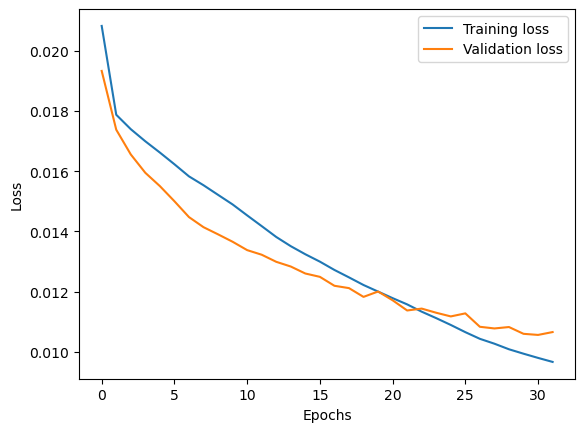

In [139]:
#Training and Validation Loss
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [141]:
# Prepare the test dataset for LSTM autoencoder
X_test = create_dataset(df_lstm_test, timesteps)

In [143]:
reconstructed_data = autoencoder.predict(X)

2573/2573 [==============================] - 43s 17ms/step


In [144]:
reconstructed_data_test = autoencoder.predict(X_test)

8052/8052 [==============================] - 144s 18ms/step


In [145]:
print("Shape of X: ", X.shape)
print("Shape of reconstructed_data: ", reconstructed_data.shape)

Shape of X:  (82312, 20, 42)
Shape of reconstructed_data:  (82312, 20, 42)


In [150]:
print("Shape of X: ", X_test.shape)

Shape of X:  (257653, 20, 42)


**Trying the LSTM AE separately for anomaly detection**

(0.0, 0.5)

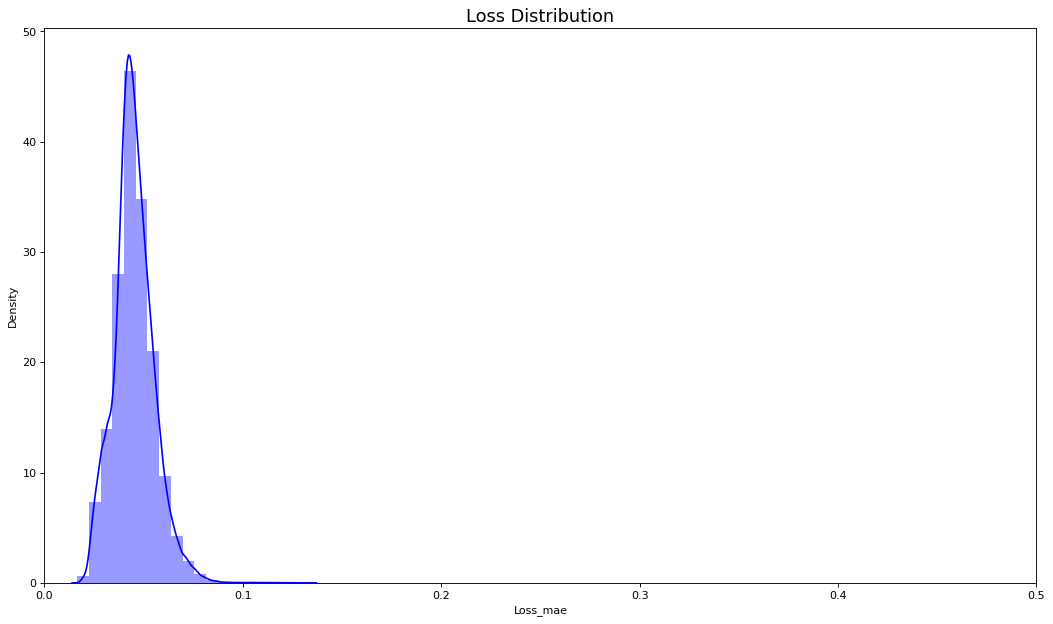

In [152]:
# Calculate the mean absolute error (MAE) between the original and reconstructed data
mae_loss_per_timestep = np.mean(np.abs(X_test - reconstructed_data_test), axis=2)
mae_loss = np.mean(mae_loss_per_timestep, axis=1)

# Convert the MAE loss to a DataFrame
mae_loss_df = pd.DataFrame(mae_loss, columns=['Loss_mae'])
mae_loss_df.index = df_lstm_test.index[:mae_loss_df.shape[0]]

# Plot the loss distribution
plt.figure(figsize=(16, 9), dpi=80)
plt.title("Loss Distribution", fontsize=16)
sns.distplot(mae_loss_df['Loss_mae'], bins=20, kde=True, color='blue')
plt.xlim([0.0, 0.5])


Number of anomalies found:  72587


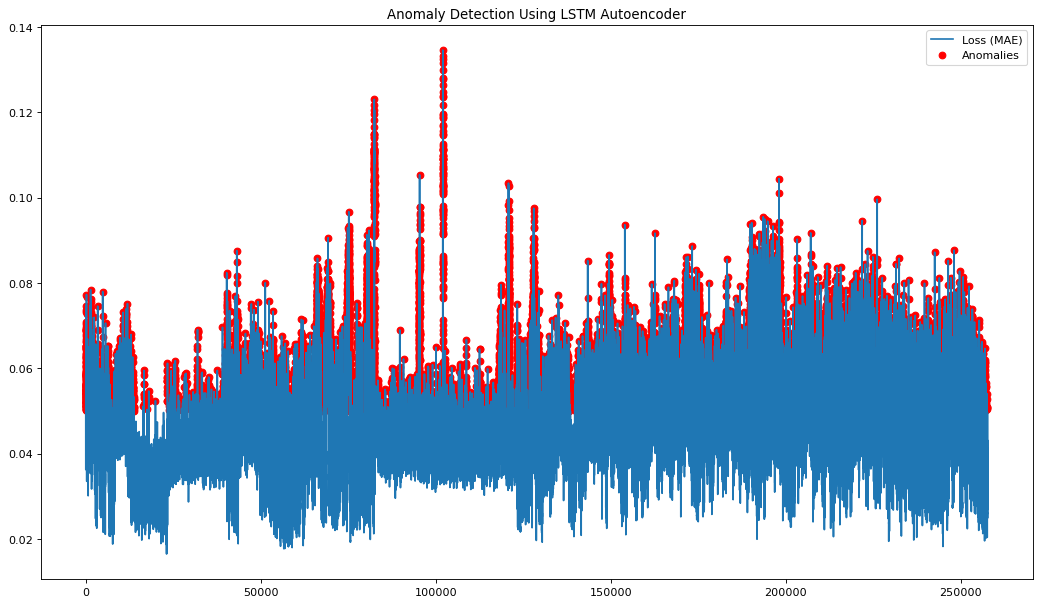

In [259]:
# Set a threshold for anomalies
threshold = 0.05

# Identify data points with an MAE higher than the threshold as anomalies
anomalies = mae_loss_df[mae_loss_df['Loss_mae'] > threshold]
print("Number of anomalies found: ", len(anomalies))

# Visualize the anomalies on a plot
plt.figure(figsize=(16, 9), dpi=80)
plt.plot(df_lstm_test.index[:mae_loss_df.shape[0]], mae_loss_df['Loss_mae'], label="Loss (MAE)")
plt.scatter(anomalies.index, anomalies['Loss_mae'], color='red', label="Anomalies")
plt.title("Anomaly Detection Using LSTM Autoencoder")
plt.legend()
plt.show()

In [260]:
# Add a new column 'lstm_anomalies' with all 1s
mae_loss_df['lstm_anomalies'] = 1

# Find the indices of the detected anomalies
anomaly_indices = mae_loss_df[mae_loss_df['Loss_mae'] > threshold].index


# Set the 'lstm_anomalies' values to -1 for the detected anomalies
mae_loss_df.loc[anomaly_indices, 'lstm_anomalies'] = -1
len(anomaly_indices)

72587

In [261]:
mae_loss_df 

,Loss_mae,lstm_anomalies
0,0.058344,-1
1,0.057362,-1
2,0.054265,-1
3,0.052104,-1
4,0.052754,-1
...,...,...
257648,0.027227,1
257649,0.028085,1
257650,0.031944,1
257651,0.033156,1


In [165]:
mae_loss_df.iloc[20:]['lstm_anomalies'].values

array([-1, -1, -1, ...,  1,  1,  1], dtype=int64)

**The lstm_anomalies array is the results of detecting anomalies using LSTM AE as a baseline**

*************************************** ************************************************

***Calculate the residuals to use them for the hybrid model***

In [166]:
# Calculate the residuals for training
residuals = np.abs(X - reconstructed_data)

In [167]:
# Calculate the residuals for testing
residuals_test = np.abs(X_test - reconstructed_data_test)

In [168]:
# Calculate the mean residual for each feature in each window
mean_residuals = np.mean(residuals, axis=1)

In [169]:
# Calculate the mean residual for each feature in each window
mean_residuals_test = np.mean(residuals_test, axis=1)

In [171]:
# Create a DataFrame from the aggregated residuals
mean_residuals_df = pd.DataFrame(mean_residuals, columns=df_test.columns)

In [173]:
# Create a DataFrame from the aggregated residuals
mean_residuals_df_test = pd.DataFrame(mean_residuals_test, columns=df_test.columns)

In [174]:
mean_residuals_df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.022107,0.312589,0.033676,0.015864,0.001126,0.000489,0.000472,0.000386,0.098623,0.282591,...,0.018793,0.014139,0.035273,0.111376,0.005964,0.007345,0.001760,0.028327,0.082335,0.281455
1,0.019853,0.273466,0.032483,0.013607,0.001131,0.000488,0.000487,0.000389,0.092427,0.232229,...,0.018326,0.013202,0.035066,0.123917,0.006127,0.007461,0.001896,0.027956,0.103085,0.238710
2,0.017823,0.249652,0.031122,0.012847,0.001050,0.000475,0.000491,0.000441,0.093605,0.197061,...,0.017939,0.012417,0.033340,0.123253,0.005752,0.006781,0.001916,0.028681,0.109531,0.204900
3,0.015232,0.239515,0.031124,0.012447,0.000951,0.000457,0.000472,0.000522,0.097590,0.185483,...,0.016780,0.011134,0.032684,0.126197,0.005240,0.005736,0.002032,0.028669,0.117710,0.184777
4,0.013305,0.251723,0.029298,0.012716,0.000812,0.000431,0.000445,0.000664,0.101502,0.199699,...,0.015466,0.010115,0.027494,0.118388,0.004213,0.004299,0.002307,0.032976,0.115893,0.189188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82307,0.029019,0.051338,0.050247,0.029900,0.001600,0.001900,0.001577,0.001612,0.153898,0.097640,...,0.023883,0.021112,0.016907,0.029671,0.006001,0.006113,0.004356,0.038598,0.052748,0.008423
82308,0.029244,0.067181,0.050703,0.030738,0.001508,0.001944,0.001526,0.001628,0.156298,0.108014,...,0.024501,0.023451,0.020117,0.030527,0.006268,0.007238,0.003899,0.042367,0.059280,0.008031
82309,0.025831,0.068764,0.076553,0.025846,0.001863,0.001689,0.001627,0.001580,0.153499,0.076955,...,0.024852,0.021085,0.023706,0.030717,0.004152,0.005596,0.003780,0.042211,0.052864,0.008414
82310,0.026942,0.119893,0.053166,0.027871,0.001806,0.001337,0.001553,0.001397,0.162713,0.133864,...,0.024677,0.022678,0.026596,0.027880,0.005645,0.006533,0.003847,0.043482,0.050325,0.056861


In [175]:
mean_residuals_df_test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.024151,0.296354,0.030315,0.150069,0.001078,0.000509,0.000533,0.000416,0.102879,0.291014,...,0.018704,0.013801,0.030486,0.117189,0.005436,0.006825,0.001416,0.027807,0.096512,0.274394
1,0.021704,0.275240,0.029313,0.150720,0.001081,0.000516,0.000552,0.000432,0.098257,0.263491,...,0.019057,0.012791,0.029728,0.126723,0.005580,0.006880,0.001420,0.028335,0.114446,0.248174
2,0.020400,0.264319,0.026101,0.148682,0.001008,0.000483,0.000565,0.000481,0.096795,0.241930,...,0.019304,0.011905,0.025696,0.121574,0.005111,0.006195,0.001341,0.031380,0.117509,0.224629
3,0.017571,0.255882,0.025637,0.148022,0.000886,0.000455,0.000539,0.000569,0.098886,0.210890,...,0.018780,0.011298,0.021262,0.120489,0.004565,0.005039,0.001515,0.034363,0.121946,0.196211
4,0.015615,0.265043,0.025936,0.145538,0.000777,0.000456,0.000500,0.000679,0.102708,0.214001,...,0.019462,0.012205,0.015316,0.112645,0.003829,0.003833,0.001746,0.038884,0.119634,0.193333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257648,0.002367,0.019806,0.012654,0.160567,0.001038,0.000312,0.000902,0.000439,0.051573,0.007773,...,0.123269,0.127160,0.161065,0.068602,0.005086,0.004099,0.000839,0.122554,0.074416,0.003850
257649,0.004214,0.015610,0.011364,0.160599,0.001011,0.000235,0.000803,0.000352,0.056161,0.013107,...,0.118064,0.121442,0.163876,0.084077,0.004528,0.004239,0.000719,0.116808,0.087740,0.004013
257650,0.006379,0.026113,0.026816,0.145179,0.001777,0.000546,0.001277,0.000768,0.057647,0.050221,...,0.105588,0.107403,0.144198,0.090229,0.004995,0.006406,0.003547,0.105088,0.095304,0.008755
257651,0.004425,0.018109,0.024929,0.149823,0.001621,0.000572,0.001239,0.000788,0.054536,0.044936,...,0.124032,0.125398,0.148751,0.094487,0.005166,0.005642,0.004268,0.122293,0.100812,0.006691


In [176]:
dfg=df.copy()

In [177]:
original_df = df_test.iloc[20:]

In [178]:
original_df

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
20,0.000010,119,0,5,2,0,2170,0,100000.002500,254,...,1,1,1,2,0,0,0,1,2,0
21,0.000009,119,0,5,2,0,202,0,111111.107200,254,...,1,1,1,2,0,0,0,1,2,0
22,0.000010,119,0,5,2,0,1334,0,100000.002500,254,...,1,1,1,3,0,0,0,1,3,0
23,0.000005,119,0,5,2,0,2058,0,200000.005100,254,...,2,2,1,3,0,0,0,2,3,0
24,0.000003,119,0,5,2,0,286,0,333333.321500,254,...,2,2,1,3,0,0,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,119,2,5,2,0,114,0,111111.107200,254,...,24,24,13,24,0,0,0,24,24,0
257669,0.505762,113,0,4,10,8,620,354,33.612649,254,...,1,1,1,2,0,0,0,1,1,0
257670,0.000009,119,2,5,2,0,114,0,111111.107200,254,...,3,3,3,13,0,0,0,3,12,0
257671,0.000009,119,2,5,2,0,114,0,111111.107200,254,...,30,30,14,30,0,0,0,30,30,0


# VAR

In [180]:
residuals2 = mean_residuals_df.values

In [502]:
#Testing the stationary of data
def test_stationarity(data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(data, autolag='AIC')
    else:
        adf_test = adfuller(data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [503]:
adf_test_results = {
    col: test_stationarity(mean_residuals_df, col)
    for col in mean_residuals_df.columns
}
adf_test_results

{'dur': 'Stationary',
 'proto': 'Stationary',
 'service': 'Stationary',
 'state': 'Stationary',
 'spkts': 'Stationary',
 'dpkts': 'Stationary',
 'sbytes': 'Stationary',
 'dbytes': 'Stationary',
 'rate': 'Stationary',
 'sttl': 'Stationary',
 'dttl': 'Stationary',
 'sload': 'Stationary',
 'dload': 'Stationary',
 'sloss': 'Stationary',
 'dloss': 'Stationary',
 'sinpkt': 'Stationary',
 'dinpkt': 'Stationary',
 'sjit': 'Stationary',
 'djit': 'Stationary',
 'swin': 'Stationary',
 'stcpb': 'Stationary',
 'dtcpb': 'Stationary',
 'dwin': 'Stationary',
 'tcprtt': 'Stationary',
 'synack': 'Stationary',
 'ackdat': 'Stationary',
 'smean': 'Stationary',
 'dmean': 'Stationary',
 'trans_depth': 'Stationary',
 'response_body_len': 'Stationary',
 'ct_srv_src': 'Stationary',
 'ct_state_ttl': 'Stationary',
 'ct_dst_ltm': 'Stationary',
 'ct_src_dport_ltm': 'Stationary',
 'ct_dst_sport_ltm': 'Stationary',
 'ct_dst_src_ltm': 'Stationary',
 'is_ftp_login': 'Stationary',
 'ct_ftp_cmd': 'Stationary',
 'ct_flw_h

In [504]:
# Determine the optimal lag order for the VAR model
max_lag_order = 20
model = smt.VAR(residuals2)
lag_order_results = model.select_order(max_lag_order)
optimal_lag_order = lag_order_results.aic  # Use '.bic' for BIC

In [505]:
optimal_lag_order

20

In [506]:
# Fit the VAR model with the optimal lag order
var_model = model.fit(optimal_lag_order)

In [507]:
# the VAR model's fitted values
var_fitted_values = var_model.fittedvalues

In [508]:
mean_residuals_df_test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.024151,0.296354,0.030315,0.150069,0.001078,0.000509,0.000533,0.000416,0.102879,0.291014,...,0.018704,0.013801,0.030486,0.117189,0.005436,0.006825,0.001416,0.027807,0.096512,0.274394
1,0.021704,0.275240,0.029313,0.150720,0.001081,0.000516,0.000552,0.000432,0.098257,0.263491,...,0.019057,0.012791,0.029728,0.126723,0.005580,0.006880,0.001420,0.028335,0.114446,0.248174
2,0.020400,0.264319,0.026101,0.148682,0.001008,0.000483,0.000565,0.000481,0.096795,0.241930,...,0.019304,0.011905,0.025696,0.121574,0.005111,0.006195,0.001341,0.031380,0.117509,0.224629
3,0.017571,0.255882,0.025637,0.148022,0.000886,0.000455,0.000539,0.000569,0.098886,0.210890,...,0.018780,0.011298,0.021262,0.120489,0.004565,0.005039,0.001515,0.034363,0.121946,0.196211
4,0.015615,0.265043,0.025936,0.145538,0.000777,0.000456,0.000500,0.000679,0.102708,0.214001,...,0.019462,0.012205,0.015316,0.112645,0.003829,0.003833,0.001746,0.038884,0.119634,0.193333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257648,0.002367,0.019806,0.012654,0.160567,0.001038,0.000312,0.000902,0.000439,0.051573,0.007773,...,0.123269,0.127160,0.161065,0.068602,0.005086,0.004099,0.000839,0.122554,0.074416,0.003850
257649,0.004214,0.015610,0.011364,0.160599,0.001011,0.000235,0.000803,0.000352,0.056161,0.013107,...,0.118064,0.121442,0.163876,0.084077,0.004528,0.004239,0.000719,0.116808,0.087740,0.004013
257650,0.006379,0.026113,0.026816,0.145179,0.001777,0.000546,0.001277,0.000768,0.057647,0.050221,...,0.105588,0.107403,0.144198,0.090229,0.004995,0.006406,0.003547,0.105088,0.095304,0.008755
257651,0.004425,0.018109,0.024929,0.149823,0.001621,0.000572,0.001239,0.000788,0.054536,0.044936,...,0.124032,0.125398,0.148751,0.094487,0.005166,0.005642,0.004268,0.122293,0.100812,0.006691


In [509]:
steps = len(mean_residuals_df_test)
forecasted_residuals = var_model.forecast(mean_residuals_df_test.values, steps=steps)


In [510]:
var_residuals_test = mean_residuals_df_test - forecasted_residuals

In [511]:
# Calculate the final residuals after applying the VAR model
var_residuals = residuals2[optimal_lag_order:] - var_fitted_values

In [512]:
var_residuals_df =pd.DataFrame(var_residuals, columns=df_lstm.columns)

In [513]:
#var_residuals_test = var_residuals_test.reshape(-1, var_residuals_test.shape[-1])
var_residuals_test =pd.DataFrame(var_residuals_test, columns=mean_residuals_df_test.columns)

In [514]:
scaler = StandardScaler()
scaler.fit(var_residuals_df)

# Normalize the forecasted_residuals using the fitted scaler
var_residuals_test = scaler.transform(var_residuals_test)
var_residuals_df = scaler.transform(var_residuals_df)

In [515]:
var_residuals_test

array([[  3.59587611,  23.00621143,   0.67606582, ..., -18.46899515,
         -2.01856919,  37.8147564 ],
       [  3.48722566,  21.23404216,   0.6501914 , ..., -18.52381152,
          0.67806748,  34.05322398],
       [  3.31567156,  20.62328301,   0.53826291, ..., -17.67570209,
          1.29156905,  30.92693519],
       ...,
       [ -3.28470355,  -2.53871485,  -7.4883978 , ...,  10.92633213,
          6.37918951,  -0.64516834],
       [ -3.60403066,  -3.19978517,  -7.67027302, ...,  14.38802365,
          7.28751951,  -0.93615099],
       [ -3.4750117 ,  -3.43712738,  -7.63045197, ...,  14.03051124,
          8.82493096,  -1.08573505]])

In [516]:
var_residuals_test =pd.DataFrame(var_residuals_test, columns=df_lstm.columns)
var_residuals_test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,3.595876,23.006211,0.676066,2.039619,-0.579246,-0.245972,-0.806068,-0.547021,6.012783,15.120421,...,-21.305819,-24.106195,-23.976919,2.082776,-0.291615,0.201840,-1.674122,-18.468995,-2.018569,37.814756
1,3.487226,21.234042,0.650191,3.862339,-0.819268,-0.463388,-1.042158,-0.619708,5.275793,13.288573,...,-21.646592,-24.491583,-23.838936,3.517243,-0.224222,0.331531,-2.429054,-18.523812,0.678067,34.053224
2,3.315672,20.623283,0.538263,5.763225,-0.829951,-0.613655,-1.050902,-0.594319,5.226856,12.117432,...,-21.431523,-24.393660,-24.039304,2.592049,-0.433480,0.059558,-3.251637,-17.675702,1.291569,30.926935
3,2.772003,19.802140,0.536439,7.902621,-0.889806,-0.990404,-1.030709,-0.688452,5.600940,10.089552,...,-21.240062,-24.133848,-24.940866,2.576384,-0.845976,-0.622988,-4.060443,-16.713077,2.120345,26.740573
4,2.689322,20.055995,0.722490,8.536309,-0.920404,-1.131541,-0.899748,-0.695436,5.973614,10.224374,...,-21.792404,-24.414292,-25.942430,0.924671,-1.007570,-0.957661,-4.782898,-16.226963,1.486634,25.922336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257648,-3.940522,-3.059608,-8.853252,24.347512,-1.151105,-2.843488,-0.814903,-2.426889,-0.546031,-6.394915,...,16.589746,20.470643,26.849317,5.012463,-1.542388,-1.833134,-4.769841,14.440518,2.934416,-1.336877
257649,-3.638593,-3.406206,-8.977615,24.353266,-1.182622,-2.952468,-0.933440,-2.549949,0.024735,-6.066987,...,15.503620,19.193828,27.449454,7.883857,-1.717546,-1.789484,-4.822390,13.284338,5.131804,-1.313867
257650,-3.284704,-2.538715,-7.488398,21.532478,-0.294840,-2.512800,-0.364485,-1.958868,0.209727,-3.785548,...,12.900411,16.058689,23.247672,9.025317,-1.570755,-1.113864,-3.579919,10.926332,6.379190,-0.645168
257651,-3.604031,-3.199785,-7.670273,22.382007,-0.475445,-2.476057,-0.410355,-1.929854,-0.177345,-4.110432,...,16.748902,20.077242,24.219846,9.815195,-1.517058,-1.352295,-3.263129,14.388024,7.287520,-0.936151


In [517]:
var_residuals_df

array([[ 7.98059007,  2.33534132, -0.37445824, ..., -1.26482831,
        -0.4313894 ,  3.12484019],
       [ 0.49602228,  1.20403151,  2.05674896, ..., -1.06675767,
         0.98663588,  3.16760756],
       [ 7.82320975, -0.73122219, -0.04127297, ..., -0.29985004,
         0.50628227,  2.371707  ],
       ...,
       [-0.57018125, -0.19313201,  2.38561217, ...,  0.02473978,
        -0.98332335, -0.66115517],
       [ 0.30081776,  4.67318573, -2.39399509, ...,  0.32175633,
        -0.24854676,  6.84841397],
       [ 0.25754977,  4.78025315, -1.16547207, ...,  0.38182925,
        -0.47413496,  6.26493201]])

In [518]:
original_df2 = original_df.iloc[20:]
original_df2

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
40,1.535254,113,5,4,10,10,826,1266,12.375802,62,...,1,1,1,2,0,0,1,1,3,0
41,59.995678,6,0,5,2,0,92,0,0.016668,0,...,2,2,2,2,0,0,0,2,2,1
42,0.757295,113,0,4,10,6,534,268,19.807340,254,...,1,1,1,2,0,0,0,1,2,0
43,0.759306,113,0,4,10,8,534,354,22.388865,254,...,1,1,1,3,0,0,0,1,3,0
44,1.294036,113,0,4,10,8,2516,354,13.137192,254,...,1,1,1,2,0,0,0,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0.000009,119,2,5,2,0,114,0,111111.107200,254,...,24,24,13,24,0,0,0,24,24,0
257669,0.505762,113,0,4,10,8,620,354,33.612649,254,...,1,1,1,2,0,0,0,1,1,0
257670,0.000009,119,2,5,2,0,114,0,111111.107200,254,...,3,3,3,13,0,0,0,3,12,0
257671,0.000009,119,2,5,2,0,114,0,111111.107200,254,...,30,30,14,30,0,0,0,30,30,0


# Isolation forest

In [519]:
df_lstm_test.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,1.833334e-07,0.901515,0.0,0.5,0.000094,0.0,0.000033,0.0,0.090909,0.996078,...,0.000000,0.000000,0.0,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
1,1.333334e-07,0.901515,0.0,0.5,0.000094,0.0,0.000121,0.0,0.125000,0.996078,...,0.000000,0.000000,0.0,0.015625,0.0,0.0,0.0,0.000000,0.016393,0.0
2,8.333335e-08,0.901515,0.0,0.5,0.000094,0.0,0.000073,0.0,0.200000,0.996078,...,0.000000,0.000000,0.0,0.031250,0.0,0.0,0.0,0.000000,0.032787,0.0
3,1.000000e-07,0.901515,0.0,0.5,0.000094,0.0,0.000061,0.0,0.166667,0.996078,...,0.017241,0.017241,0.0,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0
4,1.666667e-07,0.901515,0.0,0.5,0.000094,0.0,0.000146,0.0,0.100000,0.996078,...,0.017241,0.017241,0.0,0.031250,0.0,0.0,0.0,0.016949,0.032787,0.0


In [520]:
attack_labels_df = pd.DataFrame(attack_labels[20:], columns=['attack_labels'])
len(attack_labels_df)

257653

In [521]:
attack_labels_df = attack_labels_df.replace({0: 1, 1: -1})

In [522]:
counts = attack_labels_df['attack_labels'].value_counts()
print(counts)

-1    164673
 1     92980
Name: attack_labels, dtype: int64


**Random search for tunning hyperparams**

In [598]:
from sklearn.metrics import make_scorer, f1_score,recall_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import IsolationForest

# The parameters to be tested
param_dist = { 'contamination': [0.5],
              'n_estimators': list(range(1, 30)), 
              'max_samples': list(range(1, 30)), 
              'max_features':list(range(1, 30))}

# The model
if_model = IsolationForest(random_state=42)

# Create a custom scorer
accuracy = make_scorer(acc)

# The RandomizedSearchCV
random_search = RandomizedSearchCV(if_model, param_distributions=param_dist,
                                   n_iter=100, scoring=accuracy, cv=10, random_state=42)

# Fitting the model
random_search.fit(var_residuals_test, attack_labels_df)

# To see the best parameters
print(random_search.best_params_)

# To use the best model
best_if_model = random_search.best_estimator_

{'n_estimators': 1, 'max_samples': 10, 'max_features': 28, 'contamination': 0.5}


Optimizing Isolation Forest Parameters for Maximum Accuracy

**Trying IF separately as a baseline (using the first dataset we used as an input for the lstm)**

In [629]:
contamination = 0.5  # expected proportion of outliers
if_model = IsolationForest(contamination=contamination, random_state=42, n_estimators=1,max_samples=10,max_features= 28)
if_model.fit(df_lstm_test)
# Get anomaly labels: -1 for anomalies, 1 for normal data points
anomaly_scores_if = if_model.decision_function(df_lstm_test)
anomaly_labels_if = if_model.predict(df_lstm_test)
normal_data_points_count_if = np.count_nonzero(anomaly_labels_if == 1)
anomalies_count_if = np.count_nonzero(anomaly_labels_if == -1)

print(f"Number of normal data points: {normal_data_points_count_if}")
print(f"Number of anomalies: {anomalies_count_if}")

Number of normal data points: 148662
Number of anomalies: 109011


In [630]:
# Convert numpy array to pandas DataFrame/Series
anomaly_labels_if_df = pd.DataFrame(anomaly_labels_if[20:], columns=["anomaly_labels_if"])

# Concatenate along the columns (axis=1)
df2 = pd.concat([anomaly_labels_if_df, attack_labels_df.reset_index(drop=True)], axis=1)

In [631]:
# count the number of instances where both 'attack_labels' and 'anomaly_labels_if' are -1
num_common = df2[(df2['attack_labels'] == -1) & (df2['anomaly_labels_if'] == -1)].shape[0]

print(f'Number of instances where both are -1: {num_common}')

Number of instances where both are -1: 80164


In [632]:
len(anomaly_labels_if)

257673

In [633]:
df2

,anomaly_labels_if,attack_labels
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
257648,-1,-1
257649,1,-1
257650,-1,-1
257651,-1,-1


**The anomaly_labels_if columns is the results of iForest as a baseline**

******************

**IF within hybrid model (using the VAR residuals)**

In [617]:
# Get anomaly labels: -1 for anomalies, 1 for normal data points
contamination = 0.5  # expected proportion of outliers
if_model = IsolationForest(contamination=contamination, random_state=42, n_estimators=1,max_samples=10,max_features= 28)

if_model.fit(var_residuals_test)
anomaly_scores_test = if_model.decision_function(var_residuals_test)
anomaly_labels_test = if_model.predict(var_residuals_test)
normal_data_points_count = np.count_nonzero(anomaly_labels_test == 1)
anomalies_count = np.count_nonzero(anomaly_labels_test == -1)
accuracy = acc(attack_labels_df, anomaly_labels_test)
accuracy

0.7005158100235588

In [618]:
print(f"Number of normal data points: {normal_data_points_count}")
print(f"Number of anomalies: {anomalies_count}")

Number of normal data points: 129479
Number of anomalies: 128174


In [619]:
anomaly_labels_df = pd.DataFrame(anomaly_labels_test, columns=['anomaly_labels'])
anomaly_labels_if_df = pd.DataFrame(anomaly_labels_if[20:], columns=['anomaly_labels_if'])
original_df2=df_lstm_test[20:].copy()
#original_df2.set_index(Date_column_test[20:], inplace=True)
original_df2.shape

(257653, 42)

In [620]:
original_df2['anomaly_labels']=anomaly_labels_df.values
original_df2['anomaly_labels_if']=anomaly_labels_if_df.values
original_df2['attack_labels']=attack_labels_df.values
original_df2['lstm_anomalies']=mae_loss_df['lstm_anomalies'].values
result_df = original_df2.copy()
original_df2.shape

(257653, 46)

In [621]:
result_df.head(-5)
#anomaly_labels column is for the labels generated by the hybrid model
#anomaly_labels_if column is for the labels generated by the IF model separately
#lstm_anomalies column is for the labels generated by the lstm ae separately
#attack_labels column is for the original true labels

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,anomaly_labels,anomaly_labels_if,attack_labels,lstm_anomalies
20,1.666667e-07,0.901515,0.000000,0.5,0.000094,0.0,0.000149,0.0,0.100000,0.996078,...,0.0,0.0,0.0,0.000000,0.016393,0.0,-1,1,1,-1
21,1.500000e-07,0.901515,0.000000,0.5,0.000094,0.0,0.000012,0.0,0.111111,0.996078,...,0.0,0.0,0.0,0.000000,0.016393,0.0,1,1,1,-1
22,1.666667e-07,0.901515,0.000000,0.5,0.000094,0.0,0.000091,0.0,0.100000,0.996078,...,0.0,0.0,0.0,0.000000,0.032787,0.0,1,1,1,-1
23,8.333335e-08,0.901515,0.000000,0.5,0.000094,0.0,0.000142,0.0,0.200000,0.996078,...,0.0,0.0,0.0,0.016949,0.032787,0.0,1,1,1,-1
24,5.000001e-08,0.901515,0.000000,0.5,0.000094,0.0,0.000018,0.0,0.333333,0.996078,...,0.0,0.0,0.0,0.016949,0.032787,0.0,-1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257663,1.333334e-07,0.901515,0.166667,0.5,0.000094,0.0,0.000006,0.0,0.125000,0.996078,...,0.0,0.0,0.0,0.186441,0.721311,0.0,-1,-1,-1,1
257664,1.333334e-07,0.901515,0.166667,0.5,0.000094,0.0,0.000006,0.0,0.125000,0.996078,...,0.0,0.0,0.0,0.186441,0.721311,0.0,-1,-1,-1,1
257665,1.000000e-07,0.901515,0.166667,0.5,0.000094,0.0,0.000006,0.0,0.166667,0.996078,...,0.0,0.0,0.0,0.542373,0.721311,0.0,-1,-1,-1,1
257666,1.000000e-07,0.901515,0.166667,0.5,0.000094,0.0,0.000006,0.0,0.166667,0.996078,...,0.0,0.0,0.0,0.542373,0.721311,0.0,-1,-1,-1,1


In [622]:
# count the number of instances where both 'attack_labels' and 'anomaly_labels_if' are -1
num_common_anomalies = result_df[(result_df['attack_labels'] == -1) & (result_df['anomaly_labels'] == -1)].shape[0]

print(f'Number of instances where both are -1: {num_common_anomalies}')


Number of instances where both are -1: 107842


# Model Comparisons and evaluation

In [623]:
f1 = f1_score(result_df['attack_labels'], result_df['anomaly_labels_if'], pos_label=-1)
accuracy = acc(result_df['attack_labels'], result_df['anomaly_labels_if'])
precision = precision_score_f(result_df['attack_labels'], result_df['anomaly_labels_if'], pos_label=-1)
recall=recall_score(result_df['attack_labels'], result_df['anomaly_labels_if'], pos_label=-1)
print("IF evaluation :")
print("Detected anomalies:", len(result_df[result_df['anomaly_labels_if']==-1]))
print("precision-score:", precision)
print("recall:", recall)
print("F1-score:", f1)
print(f'Accuracy: {accuracy}')


IF evaluation :
Detected anomalies: 109011
precision-score: 0.735375329095229
recall: 0.4868071875778057
F1-score: 0.5858142967802283
Accuracy: 0.560043935059945


In [624]:
f1_lstm = f1_score(result_df['attack_labels'], result_df['lstm_anomalies'], pos_label=-1)
precision_score_lstm = precision_score_f(result_df['attack_labels'], result_df['lstm_anomalies'], pos_label=-1)
accuracy_lstm = acc(result_df['attack_labels'], result_df['lstm_anomalies'])
recall=recall_score(result_df['attack_labels'], result_df['lstm_anomalies'], pos_label=-1)
print("Lstm evaluation :")
print("Detected anomalies:", len(result_df[result_df['lstm_anomalies']==-1]))
print("precision-score:", precision_score_lstm)
print("recall:", recall)
print("F1-score:", f1_lstm)
print(f'Accuracy: {accuracy_lstm}')


Lstm evaluation :
Detected anomalies: 72587
precision-score: 0.8076239547026327
recall: 0.35599642928713265
F1-score: 0.49416673691309104
Accuracy: 0.5342029784244701


In [611]:
f1_h = f1_score(result_df['attack_labels'], result_df['anomaly_labels'], pos_label=-1)
accuracy_h = acc(result_df['attack_labels'], result_df['anomaly_labels'])

precision = precision_score_f(result_df['attack_labels'], result_df['anomaly_labels'], pos_label=-1)
recall=recall_score(result_df['attack_labels'], result_df['anomaly_labels'], pos_label=-1)

print("Hybrid model  evaluation :")
print("Detected anomalies:", len(result_df[result_df['anomaly_labels']==-1]))
print("precision-score:", precision)
print("recall:", recall)
print("F1-score:", f1_h)
print(f'Accuracy: {accuracy_h}')


Hybrid model  evaluation :
Detected anomalies: 128174
precision-score: 0.8413718850937008
recall: 0.6548857432608868
F1-score: 0.7365074595266471
Accuracy: 0.7005158100235588
